In [1]:
# ✅ ETF 與台積電報酬率完整批次分析專題版 (整合版)

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import platform
import os
from scipy.stats import zscore

In [2]:
# ✅ 字體設定（支援跨平台中文）
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = ['Arial Unicode MS']
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = ['Microsoft JhengHei']
else:
    plt.rcParams['font.family'] = ['Noto Sans CJK TC']

plt.rcParams['axes.unicode_minus'] = False


In [3]:
# ✅ 資料參數設定
base_stock_symbol = "2330.TW"
base_stock_name = "台積電"

target_list = [
    {"symbol": "0050.TW", "name": "0050元大台灣50ETF"},
    {"symbol": "0056.TW", "name": "0056高股息ETF"},
    {"symbol": "00878.TW", "name": "00878高股息ETF"},
    {"symbol": "00692.TW", "name": "富邦公司治理ETF"}
]
start_date = "2022-01-01"
end_date = "2025-04-30"

In [4]:
# ✅ 建立儲存資料夾
os.makedirs("ETF分析圖表", exist_ok=True)


In [5]:
# ✅ 下載台積電資料
base_data = yf.download(base_stock_symbol, start=start_date, end=end_date)
base_data['Return'] = base_data['Close'].pct_change()

Failed to get ticker '2330.TW' reason: Failed to perform, curl: (60) SSL certificate problem: unable to get local issuer certificate. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['2330.TW']: CertificateVerifyError('Failed to perform, curl: (60) SSL certificate problem: unable to get local issuer certificate. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


YF.download() has changed argument auto_adjust default to True


In [15]:
print(base_data)

Price            Close        High         Low        Open    Volume    Return
Ticker         2330.TW     2330.TW     2330.TW     2330.TW   2330.TW          
Date                                                                          
2022-01-03  591.801575  592.739454  579.609149  580.547028  69089158       NaN
2022-01-04  615.248474  615.248474  603.993929  604.931808  79434666  0.039620
2022-01-05  609.621277  627.440976  605.869761  627.440976  69593809 -0.009146
2022-01-06  603.994019  605.869776  596.490987  598.366745  53210211 -0.009231
2022-01-07  594.615173  605.869719  592.739416  603.056083  38249908 -0.015528
...                ...         ...         ...         ...       ...       ...
2025-04-23  873.000000  873.000000  848.000000  853.000000  37863656  0.069853
2025-04-24  864.000000  886.000000  859.000000  886.000000  32238198 -0.010309
2025-04-25  888.000000  901.000000  886.000000  900.000000  34640282  0.027778
2025-04-28  897.000000  898.000000  893.000000  898.

In [7]:
# ✅ 整理所有報酬率進行長格式轉換
all_returns = []

all_returns.append(pd.DataFrame({
    '股票名稱': base_stock_name,
    '日報酬率': base_data['Return']
}))

results = []  # 儲存回歸結果

for target in target_list:
    compare_stock_symbol = target["symbol"]
    compare_stock_name = target["name"]

    print(f"\n開始分析 {compare_stock_name}...")

    compare_data = yf.download(compare_stock_symbol, start=start_date, end=end_date)
    compare_data['Return'] = compare_data['Close'].pct_change()

    # 合併報酬率
    returns = pd.DataFrame({
        f'{base_stock_symbol}_Return': base_data['Return'],
        f'{compare_stock_symbol}_Return': compare_data['Return']
    }).dropna()

    # 線性回歸
    X = returns[f'{base_stock_symbol}_Return'].values.reshape(-1, 1)
    y = returns[f'{compare_stock_symbol}_Return'].values

    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]
    intercept = model.intercept_

    # 計算 Pearson 相關係數
    corr_coef = np.corrcoef(X.flatten(), y)[0, 1]

    results.append({
        "ETF代碼": compare_stock_symbol,
        "ETF名稱": compare_stock_name,
        "斜率": slope,
        "截距": intercept,
        "R值": corr_coef
    })

    # 報酬率加入長格式
    all_returns.append(pd.DataFrame({
        '股票名稱': compare_stock_name,
        '日報酬率': compare_data['Return']
    }))

    # 畫回歸圖
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=returns[f'{base_stock_symbol}_Return'], y=returns[f'{compare_stock_symbol}_Return'], alpha=0.5)
    plt.plot(returns[f'{base_stock_symbol}_Return'], model.predict(X), color='red', label=f'y = {slope:.2f}x + {intercept:.4f}')
    plt.title(f'{base_stock_name} 與 {compare_stock_name} 報酬率回歸')
    plt.xlabel(f'{base_stock_name} 報酬率')
    plt.ylabel(f'{compare_stock_name} 報酬率')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"ETF分析圖表/{compare_stock_symbol}_回歸分析圖.png")
    plt.close()


[*********************100%***********************]  1 of 1 completed


開始分析 0050元大台灣50ETF...



[*********************100%***********************]  1 of 1 completed


開始分析 0056高股息ETF...



[*********************100%***********************]  1 of 1 completed


開始分析 00878高股息ETF...



[*********************100%***********************]  1 of 1 completed


開始分析 富邦公司治理ETF...


In [8]:
# ✅ 匯出回歸總表
result_df = pd.DataFrame(results)
result_df.to_csv("ETF分析圖表/回歸分析總表.csv", index=False)
print("\n所有回歸分析已完成。")
display(result_df)


所有回歸分析已完成。


,ETF代碼,ETF名稱,斜率,截距,R值
0,0050.TW,0050元大台灣50ETF,0.677610,-0.000090,0.941042
1,0056.TW,0056高股息ETF,0.359089,0.000139,0.660624
2,00878.TW,00878高股息ETF,0.329738,0.000187,0.664182
3,00692.TW,富邦公司治理ETF,0.602071,-0.000058,0.924344


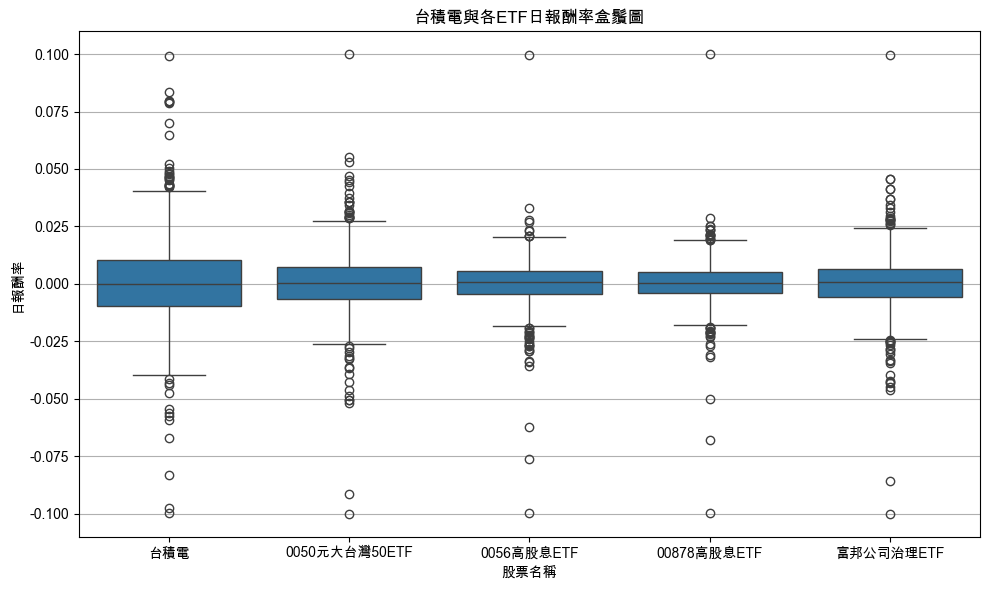

In [14]:
returns_long = pd.concat(all_returns).dropna()
plt.figure(figsize=(10, 6))
sns.boxplot(x='股票名稱', y='日報酬率', data=returns_long)
plt.title('台積電與各ETF日報酬率盒鬚圖')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("ETF分析圖表/報酬率盒鬚圖.png")
plt.show()

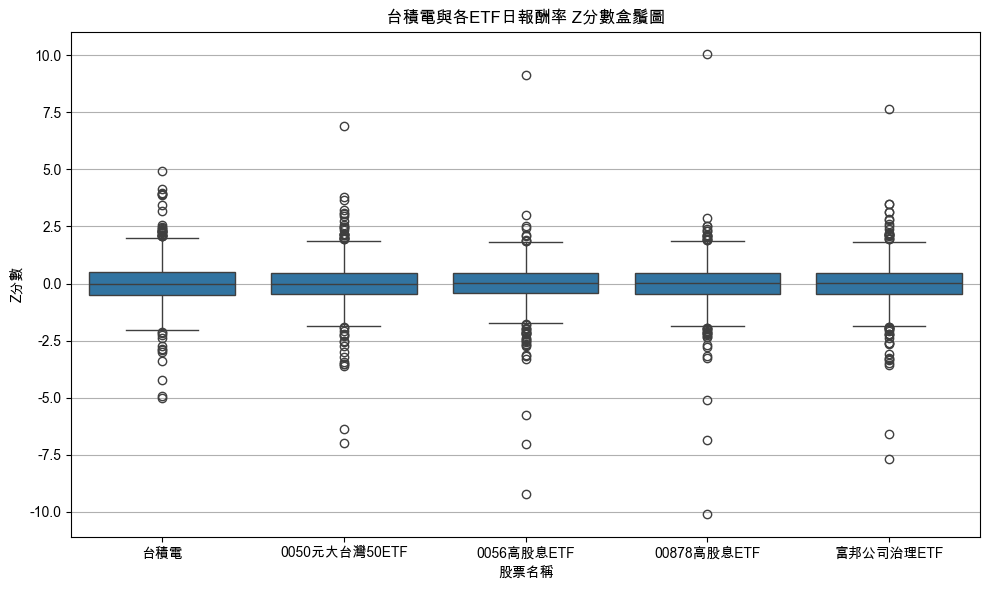


所有圖表與資料皆已完成儲存。


In [10]:
# ✅ Z分數標準化盒鬚圖
returns_long['Z分數'] = returns_long.groupby('股票名稱')['日報酬率'].transform(zscore)
plt.figure(figsize=(10, 6))
sns.boxplot(x='股票名稱', y='Z分數', data=returns_long)
plt.title('台積電與各ETF日報酬率 Z分數盒鬚圖')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("ETF分析圖表/報酬率Z分數盒鬚圖.png")
plt.show()

print("\n所有圖表與資料皆已完成儲存。")